In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
import tensorflow as tf

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [4]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})
# train_df = train_df.loc[:20]

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.1)


In [5]:
def random_crop_resize(x, crop, flip, clahe=False, clahe_clip=0.0, clahe_grid=8):
    x = np.fliplr(x) if flip else x
    x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
    x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    
    if clahe:
        x = (x * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(clahe_grid,clahe_grid))
        x = clahe.apply(x)
        info = np.iinfo(x.dtype) # Get the information of the incoming image type
        x = x.astype(np.float64) / info.max # normalize the data to 0 - 1
    
    return x

def img_augment(df):
    augment_df = pd.DataFrame(columns=df.columns)
    for index, row in tqdm_notebook(df.iterrows(),total=len(df.index)):
    #     np.random.seed(0)
        crop = np.random.randint(low=1, high=10, size=4)
        flip = np.random.choice([True, False])
        clahe = np.random.choice([True, False])
        clahe_clip = np.random.uniform(low=1, high=20, size=1)[0]
        clahe_grid = np.random.randint(low=1, high=8, size=1)[0]

        img = random_crop_resize(row['img'], crop, flip, clahe=clahe, clahe_clip=clahe_clip, clahe_grid=clahe_grid)
        img_mask = random_crop_resize(row['img_mask'], crop, flip)
        
        coverage = np.sum(img_mask) / pow(img_size_target, 2)
        coverage_class = np.ceil(coverage*10).astype(np.int_)

        augment_df = augment_df.append(
            {
                'coverage': coverage,
                'coverage_class': coverage_class,
                'depth': row['depth'],
                'img_id': row['img_id']+'_augment',
                'img_size': row['img_size'],
                'img': img,
                'img_mask': img_mask,
            }, ignore_index=True
        )

    all_df = pd.concat([df, augment_df],ignore_index=True)
    return all_df

for i in range(1):
    train_df = img_augment(train_df)
    val_df = img_augment(val_df)

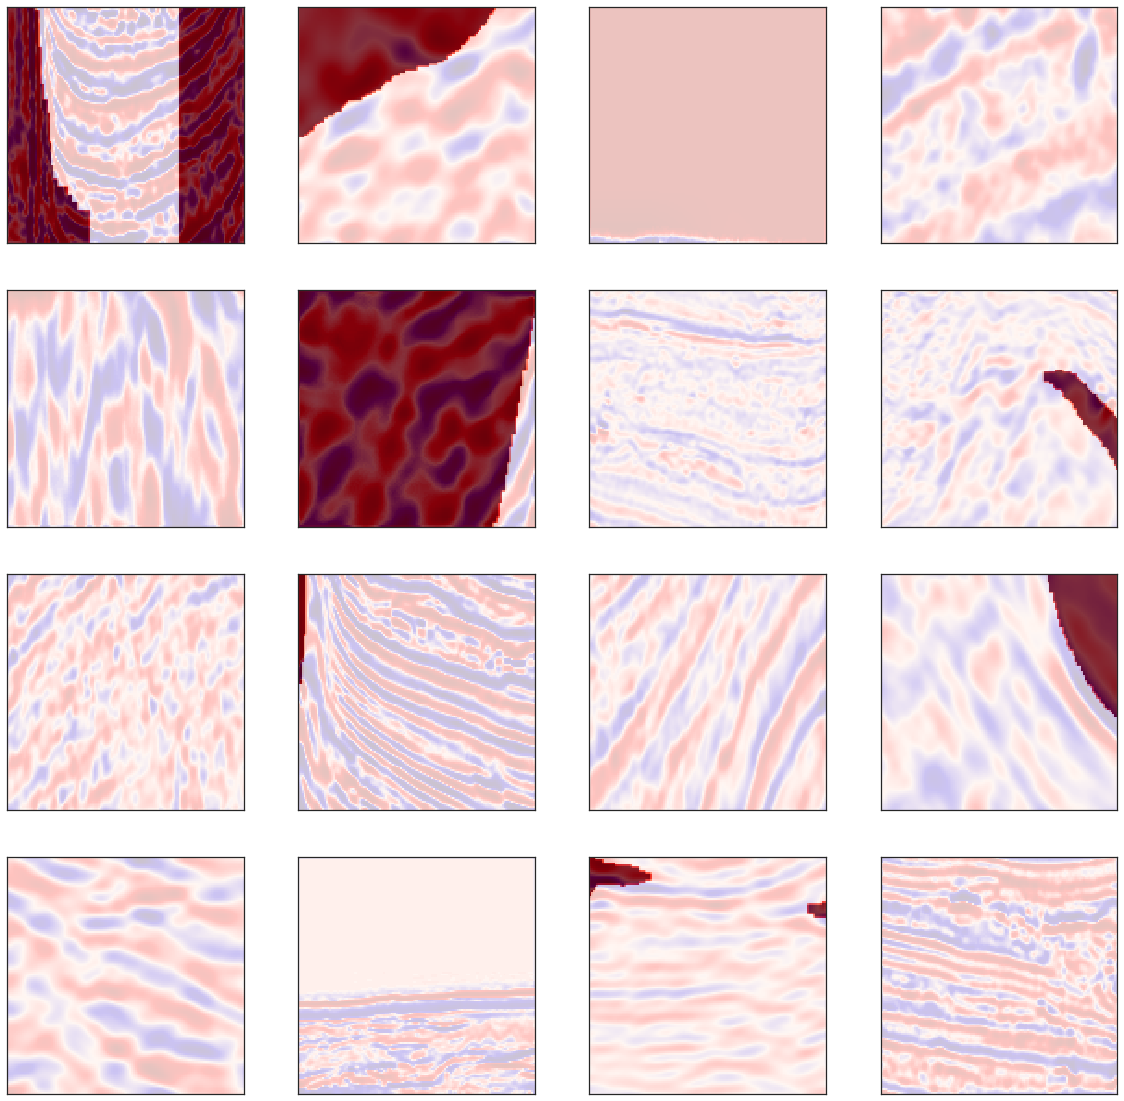

In [6]:
base_idx = 4000
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(train_df.index[base_idx:base_idx+int(max_images)]):
    img = train_df.loc[idx].img
    mask = train_df.loc[idx].img_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [7]:
X_train = np.expand_dims(np.stack((np.asarray(train_df['img'].values.tolist()))),axis=3)
X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_train = np.expand_dims(np.asarray(train_df['img_mask'].values.tolist()),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)

In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        n = conv_block(n, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
        m = conv_block(m, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=4,batchnorm=True, dropout=0.75)
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[mean_iou,"accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [ ]:
%%time
epochs = 40
batch_size = 32
callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor="val_mean_iou", mode="max"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-resnet.h5', verbose=1, save_best_only=True, monitor="val_mean_iou", mode="max")
]

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

# history = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks,
#                     validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 7200 samples, validate on 800 samples
Epoch 1/40
7200/7200 [==============================] - 94s 13ms/step - loss: 0.4047 - mean_iou: 0.4926 - acc: 0.8260 - val_loss: 0.7093 - val_mean_iou: 0.5406 - val_acc: 0.8069

Epoch 00001: val_mean_iou improved from -inf to 0.54056, saving model to model-unet-resnet.h5
Epoch 2/40
7200/7200 [==============================] - 79s 11ms/step - loss: 0.3079 - mean_iou: 0.5704 - acc: 0.8756 - val_loss: 0.4236 - val_mean_iou: 0.5895 - val_acc: 0.8165

Epoch 00002: val_mean_iou improved from 0.54056 to 0.58953, saving model to model-unet-resnet.h5
Epoch 3/40
7200/7200 [==============================] - 79s 11ms/step - loss: 0.2595 - mean_iou: 0.6072 - acc: 0.8955 - val_loss: 0.3191 - val_mean_iou: 0.6231 - val_acc: 0.8606

Epoch 00003: val_mean_iou improved from 0.58953 to 0.62310, saving model to model-unet-resnet.h5
Epoch 4/40
7200/7200 [==============================] - 79s 11ms/step - loss: 0.2346 - mean_iou: 0.6371 - acc: 0.9063 - val_loss

7200/7200 [==============================] - 78s 11ms/step - loss: 0.0746 - mean_iou: 0.8012 - acc: 0.9674 - val_loss: 0.1359 - val_mean_iou: 0.8029 - val_acc: 0.9468

Epoch 00030: val_mean_iou improved from 0.79957 to 0.80291, saving model to model-unet-resnet.h5
Epoch 31/40
7200/7200 [==============================] - 79s 11ms/step - loss: 0.0679 - mean_iou: 0.8046 - acc: 0.9695 - val_loss: 0.1343 - val_mean_iou: 0.8062 - val_acc: 0.9472

Epoch 00031: val_mean_iou improved from 0.80291 to 0.80620, saving model to model-unet-resnet.h5
Epoch 32/40
7200/7200 [==============================] - 79s 11ms/step - loss: 0.0645 - mean_iou: 0.8078 - acc: 0.9709 - val_loss: 0.1543 - val_mean_iou: 0.8094 - val_acc: 0.9398

Epoch 00032: val_mean_iou improved from 0.80620 to 0.80944, saving model to model-unet-resnet.h5
Epoch 33/40
7200/7200 [==============================] - 79s 11ms/step - loss: 0.0601 - mean_iou: 0.8110 - acc: 0.9724 - val_loss: 0.1778 - val_mean_iou: 0.8126 - val_acc: 0.9451

E

In [ ]:
fig, (ax_loss, ax_acc, ax_iou) = plt.subplots(1, 3, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train iou")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation iou")
ax_iou.plot(history.epoch, history.history["mean_iou"], label="Train iou")
ax_iou.plot(history.epoch, history.history["val_mean_iou"], label="Validation iou")

In [ ]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})
# preds_valid = model.predict({'img': train_X, 'feat': train_d}, batch_size=32, verbose=1)
# preds_valid = model.predict(train_X, batch_size=32, verbose=1)
preds_valid = model.predict(X_valid, batch_size=32, verbose=1)

In [ ]:
base_idx = 345
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.loc[idx].img
    mask = val_df.loc[idx].img_mask
    pred = preds_valid[idx].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [ ]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()